In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")

os.environ['MUJOCO_GL']='egl'

%load_ext autoreload
%autoreload 2

from envs.maze_envs import CustomPointUMazeSize3Env, CustomAntUMazeSize3Env
source_env = CustomPointUMazeSize3Env()
target_env = CustomAntUMazeSize3Env()

source_env.reset(42, None)
target_env.reset(42, None)

(array([ 0.05479121, -0.01222431,  0.8217196 ,  0.99160886, -0.07742714,
         0.09074426,  0.049823  ,  0.05721286, -0.07437728, -0.00992281,
        -0.0258404 ,  0.08535299,  0.02877302,  0.06455232, -0.01131716,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  0.        ],
       dtype=float32),
 None)

In [3]:
## Source PointUMaze; Target AntUMaze

expert_source = np.load("/home/m_bobrin/CrossDomainIL/outputs/2024-04-04/21-13-01/saved_expert/trained_expert.npy", allow_pickle=True).item()
random_source = np.load("/home/m_bobrin/CrossDomainIL/outputs/2024-04-04/21-13-01/saved_prior/random_policy.npy", allow_pickle=True).item()
random_target = np.load("/home/m_bobrin/CrossDomainIL/outputs/2024-04-04/21-43-22/saved_prior/random_policy.npy", allow_pickle=True).item()

(-0.5, 479.5, 479.5, -0.5)

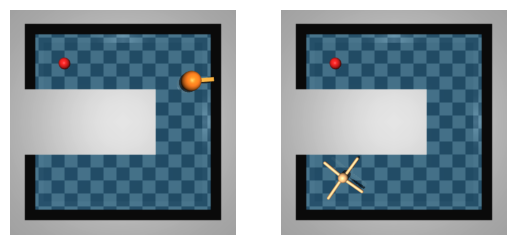

In [9]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
source_env.wrapped_env.set_xy(expert_source['observations'][80, :2])
target_env.wrapped_env.set_xy(random_target['observations'][100, :2])
axs[0].imshow(source_env.render('rgb_array'))
axs[1].imshow(target_env.render('rgb_array'))

axs[0].axis('off')
axs[1].axis('off')

In [12]:
from networks.common import MLP
import jax.numpy as jnp
from flax.training import train_state

class TrainState(train_state.TrainState):
    @classmethod
    def create(cls, model_def, inputs, apply_fn, params, tx, **kwargs):
        """Creates a new instance with ``step=0`` and initialized ``opt_state``."""
        # We exclude OWG params when present because they do not need opt states.
        variables = model_def.init(*inputs)
        params = variables.pop('params')
        opt_state = tx.init(params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            **kwargs,
        )
        

encoder_def1 = MLP(hidden_dims=[32, 16, 8, 2])
encoder_def2 = MLP(hidden_dims=[32, 16, 8, 2])


state_encoder1 = TrainState(
    apply_fn=encoder_def1.apply,
    params=
)